# Training analysis for DeepRacer

This notebook has been built based on the `DeepRacer Log Analysis.ipynb` provided by the AWS DeepRacer Team. It has been reorganised and expanded to provide new views on the training data without the helper code which was moved into utility `.py` files.

## Usage

I have expanded this notebook from to present how I'm using this information. It contains descriptions that you may find not that needed after initial reading. Since this file can change in the future, I recommend that you make its copy and reorganize it to your liking. This way you will not lose your changes and you'll be able to add things as you please.

**This notebook isn't complete.** What I find interesting in the logs may not be what you will find interesting and useful. I recommend you get familiar with the tools and try hacking around to get the insights that suit your needs.

## Contributions

As usual, your ideas are very welcome and encouraged so if you have any suggestions either bring them to [the AWS DeepRacer Community](http://join.deepracing.io) or share as code contributions.

## Training environments

Depending on whether you're running your training through the console or using the local setup, and on which setup for local training you're using, your experience will vary. As much as I would like everything to be taylored to your configuration, there may be some problems that you may face. If so, please get in touch through [the AWS DeepRacer Community](http://join.deepracing.io).

## Requirements

Before you start using the notebook, you will need to install some dependencies. If you haven't yet done so, have a look at [The README.md file](/edit/README.md#running-the-notebooks) to find what you need to install.

Apart from the install, you also have to configure your programmatic access to AWS. Have a look at the guides below, AWS resources will lead you by the hand:

AWS CLI: https://docs.aws.amazon.com/cli/latest/userguide/cli-chap-configure.html

Boto Configuration: https://boto3.amazonaws.com/v1/documentation/api/latest/guide/configuration.html

## Credits

I would like to thank [the AWS DeepRacer Community](http://join.deepracing.io) for all the feedback about the notebooks. If you'd like, follow [my blog](https://codelikeamother.uk) where I tend to write about my experiences with AWS DeepRacer.

# Log Analysis

Let's get to it.

## Imports

Run the imports block below:

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import glob
import os.path

%matplotlib inline

#Shapely Library
from shapely.geometry import Point, Polygon
from shapely.geometry.polygon import LinearRing, LineString

#Plotly Library
import plotly.graph_objects as go
import plotly.express as px
import plotly.figure_factory as ff
from plotly.subplots import make_subplots

from python import track_utils as tu
from python import cw_utils as cw
from python import log_analysis as la
from python import pirates_log_analysis as pla

import math

# Make sure your boto version is >= '1.9.133'
cw.boto3.__version__

'1.14.39'

This block below has been prepared in case you would like to make some changes to the utility code that comes with this notebook. It will reload track_utlis.py, log_analysis.py and cw_utils.py without the need to reload the notebook. In normal usage of the notebook you will not need it.

In [35]:
# reload log_analysis and the rest of stuff here if needed
# (handy for code updates in utils, doesn't break anything if no changes)
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 300)

import importlib
importlib.reload(la)
importlib.reload(cw)
importlib.reload(tu)
importlib.reload(pla)

<module 'python.pirates_log_analysis' from 'C:\\Users\\Rogue\\Desktop\\deepracer\\aws-deepracer-utils\\Notebooks\\python\\pirates_log_analysis.py'>

## Load waypoints for the track you want to run analysis on

The track waypoint files usually show up as new races start. Be sure to check for them in repository updates. You only need to load them in the block below.

These files represent the coordinates of characteristic points of the track - the center line, inside border and outside border. Their main purpose is to visualise the track in images below. One thing that you may want to remember is that at the moment not all functions below work with all values of the coordinates. Especially some look awkward with bigger tracks or with negative coordinates. Usually there is an explanation on what to do to fix the view.

The naming of the tracks is not super consistent. I'm also not sure all of them are available in the console or locally. You may want to know that:
* London_Loop and Virtual_May19_Train_track - are the AWS DeepRacer Virtual League London Loop tracks
* Tokyo - is the AWS DeepRacer Virtual League Kumo Torakku track
* New_York - are the AWS DeepRacer Virtual League Empire City training and evaluation tracks
* China - are the AWS Deepracer Virtual League Shanghai Sudu training and evaluation tracks
* reinvent_base - is the re:Invent 2019 racing track

There are also other tracks that you may want to explore. Each of them has its own properties that you might find useful for your model.

Remeber that evaluation npy files are a community effort to visualise the tracks in the trainings, they aren't 100% accurate.

Tracks Available:

In [14]:
# Conveniently list available tracks to analyze
available_track_files = glob.glob("../Tracks/**.npy")
available_track_names = list(map(lambda x: os.path.basename(x).split('.npy')[0], available_track_files))
available_track_names

['reinvent_base']

Take the name from results above and paste below to load the key elements of the track and view the outline of it.

Loaded 71 waypoints


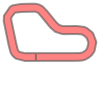

In [15]:
TRACK_NAME = "reinvent_base"
l_center_line, l_inner_border, l_outer_border, road_poly = tu.load_track(TRACK_NAME, "../")
road_poly

## Get the logs

Depending on which way you are training your model, you will need a different way to load the data.

**AWS DeepRacer Console**
The logs are being stored in CloudWatch, in group `/aws/robomaker/SimulationJobs`. You will be using boto3 to download them based on the training ID (stream name prefix). If you wish to bulk export the logs from Amazon Cloudwatch to Amazon S3 :: https://docs.aws.amazon.com/AmazonCloudWatch/latest/logs/S3ExportTasks.html

**DeepRacer for Dummies/ARCC local training**
Those two setups come with a container that runs Jupyter Notebook (as you noticed if you're using one of them and reading this text). Logs are stored in `/logs/` and you just need to point at the latest file to see the current training. The logs are split for long running training if they exceed 500 MB. The log loading method has been extended to support that.

**Chris Rhodes' repo**
Chris repo doesn't come with logs storage out of the box. I would normally run `docker logs dr > /path/to/logfile` and then load the file.

Below I have prepared a section for each case. In each case you can analyse the logs as the training is being run, just in case of the Console you may need to force downloading of the logs as the `cw.download_log` method has a protection against needless downloads.

Select your preferred way to get the logs below and you can get rid of the rest.

In [36]:
# AWS DeepRacer Console
log_dir = "pirates-onepiece-v2-v1-SF-i2-1"
sagemaker_fname =  glob.glob("../Logs/"+log_dir+"/logs/training/**sagemaker.log")[0]
robomaker_fname = glob.glob("../Logs/"+log_dir+"/logs/training/**robomaker.log")[0]
sagemaker_fname,robomaker_fname

('../Logs/pirates-onepiece-v2-v1-SF-i2-1/logs/training\\training-20201026092558-IRgI2ap4TKO4qSdCFx5Png-sagemaker.log',
 '../Logs/pirates-onepiece-v2-v1-SF-i2-1/logs/training\\training-20201026092559-IRgI2ap4TKO4qSdCFx5Png-robomaker.log')

## Load the trace training log

Now that the data is downloaded, we need to load it into memory. We will first read it from file and then convert to data frames in Pandas. [Pandas](https://pandas.pydata.org/) is a Python library for handling and analysing large amounts of data series. Remember this name, you may want to learn more about how to use it to get more information that you would like to get from the logs. Examples below are hardly scratching the surface.

One important information to enter is the setting of your Episodes per iteration hyperparameter. This is used to group the episodes into iterations. This information is valuable when later looking at graphs showing how the training progresses per iteration. You can use it to detect which iteration gave you better outcomes and, if in local training, you could move to that iteration's outcome for submissions in the AWS DeepRacer League or  for continuing the training.

The log files you have just gathered above have lines like this one:
```
SIM_TRACE_LOG:799,111,1.7594,4.4353,3.0875,-0.26,2.50,2,1.0000,False,True,71.5802,49,17.67,1555554451.1110387
```
This is all that matters for us. The first two are some tests I believe and when loading they get skipped, then each next line has the following fields:
* episode number
* step number
* x coordinate
* y coordinate
* yaw of the car (where the car is heading)
* decision about turning (turn value from your action space)
* decision about throttle (speed value from your action space)
* decision index (value from your action space)
* reward value
* is the car going backwards
* are all wheels on track?
* progress in the lap
* closest waypoint
* track length
* timestamp

`la.load_data` and then `la.convert_to_pandas` read it and prepare for your usage. Sorting the values may not be needed, but I have experienced under some circumstances that the log lines were not ordered properly.

In [37]:
def parse_robomaker_logs_hyperparameters(robomaker_fname, hyperparameter_name):
    hyperparameter_name = hyperparameter_name.replace('_', '[_]')
    os_cmd = "cat %s | grep -E '^[ ]+[\"]%s[\"][:]' | cut -d':' -f2 | cut -d',' -f1 | sed -e 's/^[ ]*//g'" % (robomaker_fname, hyperparameter_name)
    os_output = !$os_cmd
    return os_output[0]

# use this manually if using from windows
# EPISODES_PER_ITERATION = 40

EPISODES_PER_ITERATION = int(parse_robomaker_logs_hyperparameters(robomaker_fname, 'num_episodes_between_training'))
NUM_EPOCHS = int(parse_robomaker_logs_hyperparameters(robomaker_fname, 'num_epochs'))

print ('EPISODES_PER_ITERATION: %s' % EPISODES_PER_ITERATION)
print ('NUM_EPOCHS: %s' % NUM_EPOCHS)

EPISODES_PER_ITERATION: 40
NUM_EPOCHS: 10


In [38]:
data = la.load_data(robomaker_fname)
df = la.convert_to_pandas(data, episodes_per_iteration=EPISODES_PER_ITERATION)
df = df.sort_values(['episode', 'steps'])

# personally I think normalizing can mask too high rewards so I am commenting it out,
# but you might want it.
# la.normalize_rewards(df)

#Uncomment the line of code below to evaluate a different reward function
# la.new_reward(df, l_center_line, 'reward.new_reward') #, verbose=True)

In [39]:
# # Code to cut down the training till the checkpoint episode
# checkpoint_ep = 3250
# ep = df[df['episode']==checkpoint_ep]
# step_no = int(ep.iloc[[-1]].index.tolist()[0])
# df = df.iloc[0:step_no]

## New reward

Note the last line above: it takes a reward class from log-analysis/rewards, imports it, instantiates and recalculates reward values based on the data from the log. This lets you do some testing before you start training and rule out some obvious things.

*If you find this confusing, don't worry, because it is confusing. You can safely ignore it for now and come back to it later.*

This operation is possible because the logs contain all information needed to recreate the params for a given step. That said some could be implemented better and some were ignored for now and should be implemented.

The sample reward mentioned in that line is located in `log-analysis/rewards/reward_sample.py` and looks like this:

```
from time import time


class Reward:
    def __init__(self, verbose=False):
        self.previous_steps = None
        self.initial_time = None
        self.verbose = verbose

    @staticmethod
    def get_time(params):
        # remember: this will not return time before
        # the first step has completed so the total
        # time for lap will be lower by about 0.2s
        return params.get('timestamp', None) or time()

    def reward_function(self, params):
        if self.previous_steps is None \
                or self.previous_steps > params['steps']:
            # new lap!
            self.initial_time = self.get_time(params)
        else:
            # we're continuing a lap
            pass

        steering_factor = 1.0

        if abs(params['steering_angle']) > 14:
            steering_factor = 0.7

        reward = float(steering_factor)

        self.previous_steps = params['steps']

        if self.verbose:
            print(params)

        return reward


reward_object = Reward()


def reward_function(params):
    return reward_object.reward_function(params)

```

After some imports a class is declared, it's called `Reward`, then the class is instantiated and a function `reward_function` is declared. This somewhat bloated structure has a couple benefits:
* It works in console/local training for actual training
* It lets you reload the definition for class Reward and retry the reward function multiple times after changes without much effort
* If you want to rely on state carried over between the steps, it's all contained in a reward object 

The reward class hides two or three tricks for you:
* `get_time` lets you abstract from machine time in log analysis - the supporting code adds one extra param, `timestamp`. That lets you get the right time value in new_reward function
* the first condition allows detecting the beginning of an episode or even start of training you can use it for some extra operations between the episodes
* `verbose` can be used to provide some noisier prints in the reward function - you can switch them on when loading the reward function above.

Just remember: not all params are provided, you are free to implement them and raise a Pull Request for log_analysis.df_to_params method.

If you just wrap your reward function like in the above example, you can use it in both log analysis notebook and the training.

Final warning: there is a loss of precision in the logs (rounded numbers) and also potentially potential bugs. If you find any, please fix, please report.

## Graphs

The original notebook has provided some great ideas on what could be visualised in the graphs. Below examples are a slightly extended version. Let's have a look at what they are presenting and what this may mean to your training.

### Training progress

As you have possibly noticed by now, training episodes are grouped into iterations and this notebook also reflects it. What also marks it are checkpoints in the training. After each iteration a set of ckpt files is generated - they contain outcomes of the training, then a model.pb file is built based on that and the car begins a new iteration. Looking at the data grouped by iterations may lead you to a conclusion, that some earlier checkpoint would be a better start for a new training. While this is limited in the AWS DeepRacer Console, with enough disk space you can keep all the checkpoints along the way and use one of them as a start for new training (or even as a submission to a race).

While the episodes in a given iteration are a mixture of decision process and random guesses, mean results per iteration may show a specific trend. Mean values are accompanied by standard deviation to show the concentration of values around the mean.

#### Rewards per Iteration

You can see these values as lines or dots per episode in the AWS DeepRacer console. When the reward goes up, this suggests that a car is learning and improving with regards to a given reward function. **This does not have to be a good thing.** If your reward function rewards something that harms performance, your car will learn to drive in a way that will make results worse.

At first the rewards just grow if the progress achieved grows. Interesting things may happen slightly later in the training:

* The reward may go flat at some level - it might mean that the car can't get any better. If you think you could still squeeze something better out of it, review the car's progress and consider updating the reward function, the action space, maybe hyperparameters, or perhaps starting over (either from scratch or from some previous checkpoint)
* The reward may become wobbly - here you will see it as a mesh of dots zig-zagging. It can be a gradually growing zig-zag or a roughly stagnated one. This usually means the learning rate hyperparameter is too high and the car started doing actions that oscilate around some local extreme. You can lower the learning rate and hope to step closer to the extreme. Or run away from it if you don't like it
* The reward plunges to near zero and stays roughly flat - I only had that when I messed up the hyperparameters or the reward function. Review recent changes and start training over or consider starting from scratch

The Standard deviation says how close from each other the reward values per episode in a given iteration are. If your model becomes reasonably stable and worst performances become better, at some point the standard deviation may flat out or even decrease. That said, higher speeds usually mean there will be areas on track with higher risk of failure. This may bring the value of standard deviation to a higher value and regardless of whether you like it or not, you need to accept it as a part of fighting for significantly better times.

#### Time per iteration

I'm not sure how useful this graph is. I would worry if it looked very similar to the reward graph - this could suggest that slower laps will be getting higher rewards. But there is a better graph for spotting that below.

#### Progress per Iteration

This graph usually starts low and grows and at some point it will get flatter. The maximum value for progress is 100% so it cannot grow without limits. It usually shows similar initial behaviours to reward and time graphs. I usually look at it when I alter an action in training. In such cases this graph usually dips a bit and then returns or goes higher.

#### Total reward per episode

This graph has been taken from the orignal notebook and can show progress on certain groups of behaviours. It usually forms something like a triangle, sometimes you can see a clear line of progress that shows some new way has been first taught and then perfected.

#### Mean completed lap times per iteration

Once we have a model that completes laps reasonably often, we might want to know how fast the car gets around the track. This graph will show you that. I use it quite often when looking for a model to shave a couple more miliseconds. That said it has to go in pair with the last one:

#### Completion rate per iteration

It represents how big part of all episodes in an iteration is full laps. The value is from range [0, 1] and is a result of deviding amount of full laps in iteration by amount of all episodes in iteration. I say it has to go in pair with the previous one because you not only need a fast lapper, you also want a race completer.

The higher the value, the more stable the model is on a given track.

### Stats for all laps

Previous graphs were mainly focused on the state of training with regards to training progress. This however will not give you a lot of information about how well your reward function is doing overall.

In such case `scatter_aggregates` may come handy. It comes with three types of graphs:
* progress/steps/reward depending on the time of an episode - of this I find reward/time and new_reward/time especially useful to see that I am rewarding good behaviours - I expect the reward to time scatter to look roughly triangular
* histograms of time and progress - for all episodes the progress one is usually quite handy to get an idea of model's stability
* progress/time_if_complete/reward to closest waypoint at start - these are really useful during training as they show potentially problematic spots on track. It can turn out that a car gets best reward (and performance) starting at a point that just cannot be reached if the car starts elsewhere, or that there is a section of a track that the car struggles to get past and perhaps it's caused by an aggressive action space or undesirable behaviour prior to that place

Side note: `time_if_complete` is not very accurate and will almost always look better for episodes closer to 100% progress than in case of those 50% and below.

new reward not found, using reward as its values
Number of episodes =  1023
Number of iterations =  26


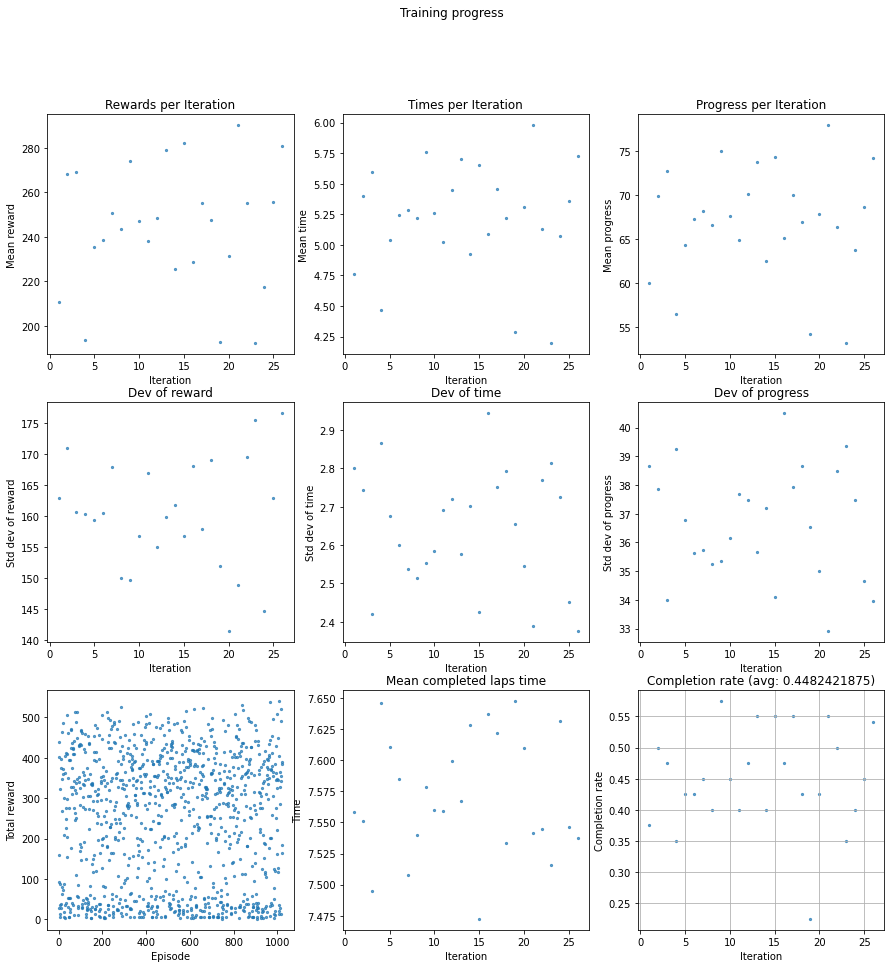

<Figure size 432x288 with 0 Axes>

In [40]:
simulation_agg = la.simulation_agg(df)
la.analyze_training_progress(simulation_agg, title='Training progress')

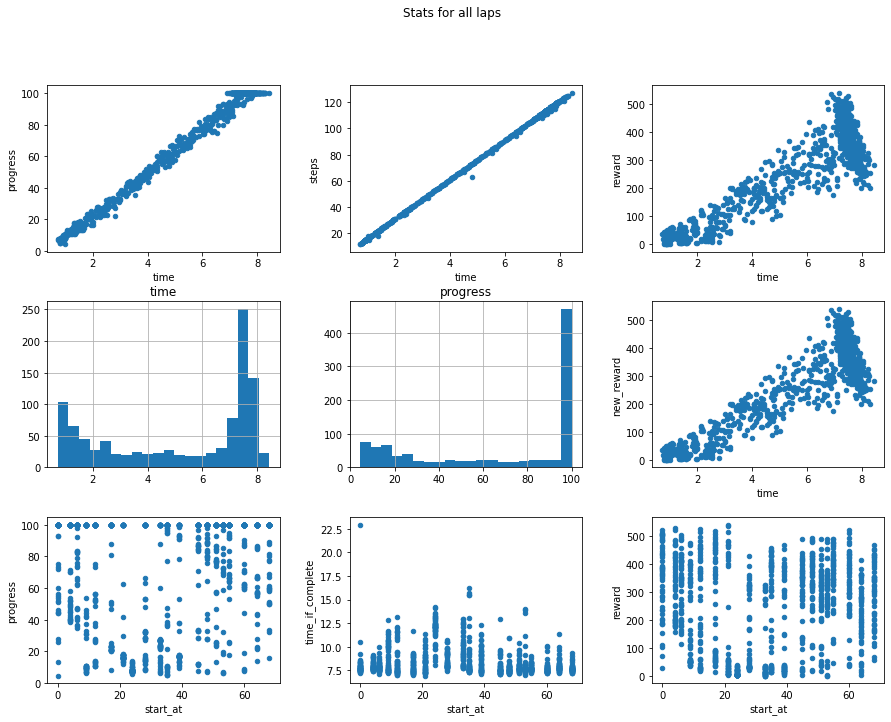

<Figure size 432x288 with 0 Axes>

In [41]:
la.scatter_aggregates(simulation_agg, 'Stats for all laps')

### Stats for complete laps
The graphs here are same as above, but now I am interested in other type of information:
* does the reward scatter show higher rewards for lower completion times? If I give higher reward for a slower lap it might suggest that I am training the car to go slow
* what does the time histogram look like? With enough samples available the histogram takes a normal distribution graph shape. The lower the mean value, the better the chance to complete a fast lap consistently. The longer the tails, the greater the chance of getting lucky in submissions
* is the car completing laps around the place where the race lap starts? Or does it only succeed if it starts in a place different to the racing one?

459


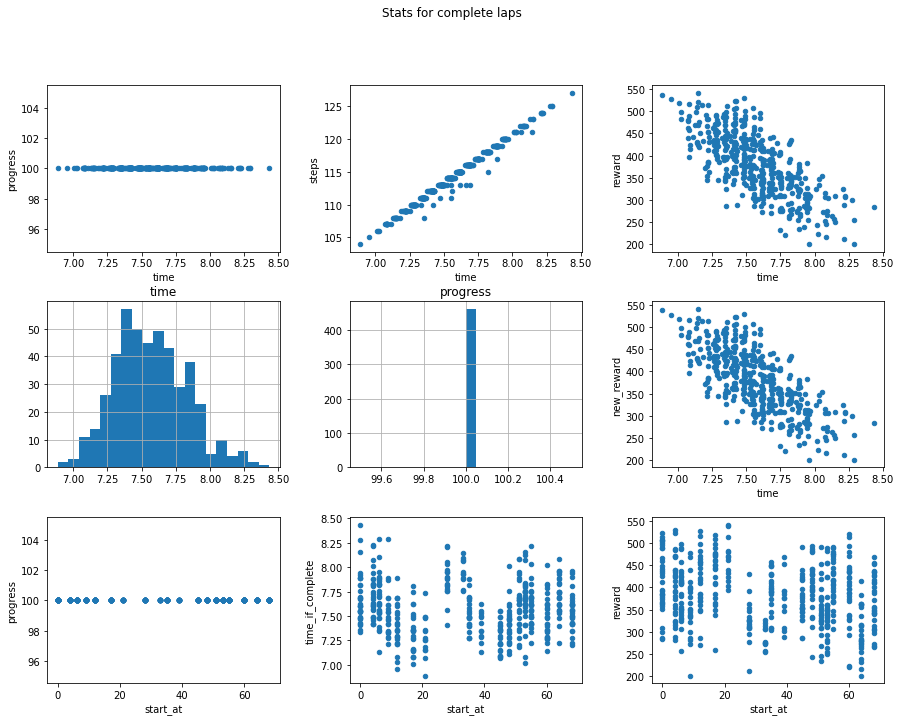

<Figure size 432x288 with 0 Axes>

In [43]:
complete_ones = simulation_agg[simulation_agg['progress']==100]
print(len(complete_ones))
if complete_ones.shape[0] > 0:
    la.scatter_aggregates(complete_ones, 'Stats for complete laps')
else:
    print('No complete laps yet.')

In [45]:
fig = go.Figure()
fig = px.histogram(complete_ones, x="time", marginal="rug",
                   hover_data={'time' : True, 'steps':True, 'iteration':True, 'episode':True, 'start_at':True, 'reward':True, 'quintile':True})
# fig = px.histogram(complete_ones,x = "time")
fig.update_xaxes(showgrid=True)
fig.show()

In [46]:
fig = go.Figure()
fig = make_subplots(rows=3, cols=2,subplot_titles=("Time", "Steps", "Time-Steps", "Time-Reward","Start_at-Time","Start_at-Steps"))
fig.add_trace(
    go.Histogram(x=complete_ones['time'] ,showlegend = False),
    row=1, col=1
)
fig.add_trace(
    go.Histogram(x=complete_ones['steps'] ,showlegend = False),
    row=1, col=2
)
fig.add_trace(
    go.Scatter(x=complete_ones['time'] ,y=complete_ones['steps'] , mode="markers",showlegend = False),
    row=2, col=1
)
fig.add_trace(
    go.Scatter(x=complete_ones['time'] ,y=complete_ones['reward'] ,mode="markers",showlegend = False),
    row=2, col=2
)
fig.add_trace(
    go.Scatter(x=complete_ones['start_at'] ,y=complete_ones['time'] , mode="markers",showlegend = False),
    row=3, col=1
)
fig.add_trace(
    go.Scatter(x=complete_ones['start_at'] ,y=complete_ones['steps'] , mode="markers",showlegend = False),
    row=3, col=2
)

fig.update_layout(height=1500, width=980, title_text="Complete Laps Analysis")
fig.show()

In [47]:
size = len(complete_ones)
p25 = round(size*0.25)

fig = go.Figure()
fig.add_trace(go.Histogram(x=complete_ones['steps'].iloc[0:p25] , name="First 25%"))
fig.add_trace(go.Histogram(x=complete_ones['steps'].iloc[(size-p25):size] , name = "Last 25%"))
fig.update_layout(title = "Steps Distribution in first and last 25%",barmode='overlay')
fig.update_traces(opacity=0.65)
fig.show()

In [48]:
fig = go.Figure()
fig.add_trace(go.Histogram(x=complete_ones['time'].iloc[0:p25] , name="First 25%"))
fig.add_trace(go.Histogram(x=complete_ones['time'].iloc[(size-p25):size] , name = "Last 25%"))
fig.update_layout(title = "Time Distribution in first and last 25%", barmode='overlay')
fig.update_traces(opacity=0.65)
fig.show()

In [49]:
df_copy = df.copy()
size = len(df_copy)
p25 = round(size*0.25)
fig = go.Figure()
fig.add_trace(go.Histogram(x=df_copy['reward'].round().iloc[0:p25] , name="First 25%"))
fig.add_trace(go.Histogram(x=df_copy['reward'].round().iloc[(size-p25):size] , name = "Last 25%"))
fig.update_layout(title = "Reward Distribution in first and last 25%", barmode='overlay')
fig.update_traces(opacity=0.65)
fig.show()

In [50]:
fig = go.Figure()
fig = px.histogram(df_copy['reward'].round(),x = "reward")
fig.update_xaxes(showgrid=True)
fig.show()

In [51]:
# Retrieve policy training data from the SageMaker Log file
trn_data = pla.parse_sagemaker_logs(sagemaker_fname)

fig = go.Figure()
fig = make_subplots(specs=[[{"secondary_y": True}]])
fig.add_trace(go.Scatter(x=trn_data['iteration'], y=trn_data['entropy'],
                    mode='lines',name='entropy',line=dict({'shape': 'spline', 'smoothing': 1.3})),secondary_y=False,)
fig.show()

### Categories analysis
We're going back to comparing training results based on the training time, but in a different way. Instead of just scattering things in relation to iteration or episode number, this time we're grouping episodes based on a certaing information. For this we use function:
```
analyze_categories(panda, category='quintile', groupcount=5, title=None)
```
The idea is pretty simple - determine a way to cluster the data and provide that as the `category` parameter (alongside the count of groups available). In the default case we take advantage of the aggregated information to which quintile an episode belongs and thus build buckets each containing 20% of episodes which happened around the same time during the training. If your training lasted for five hours, this would show results grouped per each hour.

A side note: if you run the function with `category='start_at'` and `groupcount=20` you will get results based on the waypoint closest to the starting point of an episode. If you need to, you can introduce other types of categories and reuse the function.

The graphs are similar to what we've seen above. I especially like the progress one which shows where the model tends to struggle and whether it's successful laps rate is improving or beginning to decrease. Interestingly, I also had cases where I saw the completion drop on the progress rate only to improve in a later quintile, but with a better time graph.

A second side note: if you run this function for `complete_ones` instead of `simulation_agg`, suddenly the time histogram becomes more interesting as you can see whether completion times improve.

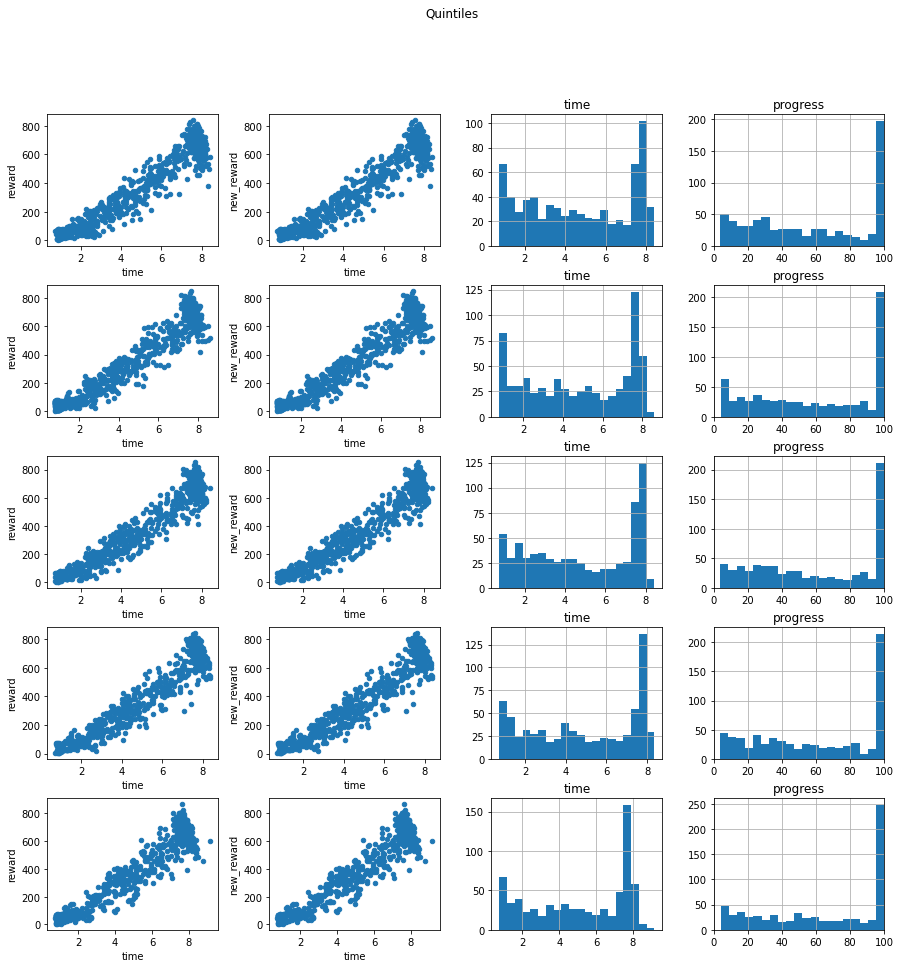

<Figure size 432x288 with 0 Axes>

In [11]:
la.analyze_categories(simulation_agg, title='Quintiles')

## Data in tables

While a lot can be seen in graphs that cannot be seen in the raw numbers, the numbers let us get into more detail. Below you will find a couple examples. If your model is behaving the way you would like it to, below tables may provide little added value, but if you struggle to improve your car's performance, they may come handy. In such cases I look for examples where high reward is giving to below-expected episode and when good episodes are given low reward.

You can then take the episode number and scatter it below, and also look at reward given per step - this can in turn draw your attention to some rewarding anomalies and help you detect some unexpected outcomes in your reward function.

There is a number of ways to select the data for display:
* `nlargest`/`nsmallest` lets you display information based on a specific value being highest or lowest
* filtering based on a field value, for instance `df[df['episode']==10]` will display only those steps in `df` which belong to episode 10
* `head()` lets you peek into a dataframe

There isn't a right set of tables to display here and the ones below may not suit your needs. Get to know Pandas more and have fun with them. It's almost as addictive as DeepRacer itself.

The examples have a short comment next to them explaining what they are showing.

In [55]:
# View ten best rewarded episodes in the training
simulation_agg.nlargest(100, 'new_reward')

iteration  episode  steps  start_at  progress      time  new_reward  \
1006         26     1006    108        21  100.0000  7.148260    540.8633   
966          25      966    104        21  100.0000  6.888093    537.4038   
841          22      841    113         4  100.0000  7.483394    529.9722   
284           8      284    105        12  100.0000  6.953907    526.2958   
660          17      660    112         0  100.0000  7.422950    523.0623   
621          16      621    112         4  100.0000  7.418350    521.9418   
1017         26     1017    108        60  100.0000  7.146329    520.7222   
845          22      845    106        17  100.0000  7.007670    517.9662   
584          15      584    107        12  100.0000  7.081085    515.5875   
86            3       86    108        21  100.0000  7.181075    513.6114   
77            2       77    109        60  100.0000  7.221604    512.7771   
220           6      220    111         0  100.0000  7.357599    512.4428   
420          11      420    102         0   93.0563  6.746885    509.0915   
805          21      805    108        17  100.0000  7.142237    509.0200   
1000         26     1000    112         0  100.0000  7.429019    507.7473   
40            2       40    114         0  100.0000  7.550421    506.3331   
200           6      200    112         0  100.0000  7.411920    505.2442   
402          11      402    111         6   98.2684  7.326701    503.8509   
500          13      500    113         0  100.0000  7.492646    499.4828   
702          18      702    108         6  100.0000  7.133011    498.1188   
224           6      224    106        12  100.0000  7.025104    497.8709   
865          22      865    111        17  100.0000  7.351726    497.6438   
980          25      980    115         0  100.0000  7.601988    494.8594   
753          19      753    111        48  100.0000  7.336775    493.8473   
237           6      237    112        60  100.0000  7.418458    492.5843   
872          22      872    110        45  100.0000  7.279783    491.2856   
574          15      574    109        51  100.0000  7.203920    491.0841   
276           7      276    111        55  100.0000  7.341417    490.9587   
1016         26     1016    113        55  100.0000  7.491005    489.8450   
255           7      255    107        53  100.0000  7.083427    489.7689   
502          13      502    111         6  100.0000  7.344532    489.5082   
365          10      365    110        17  100.0000  7.279705    488.6066   
880          23      880    111         0  100.0000  7.340769    487.8197   
80            3       80    114         0  100.0000  7.554068    487.6364   
22            1       22    111         6  100.0000  7.354117    487.0365   
413          11      413    111        48  100.0000  7.329458    486.0239   
541          14      541    115         4  100.0000  7.604316    485.4829   
341           9      341    112         4  100.0000  7.421166    484.3195   
400          11      400    102         0   92.7988  6.749737    483.0319   
684          18      684    109        12  100.0000  7.219185    482.9620   
526          14      526    113        21  100.0000  7.494126    482.9522   
253           7      253    109        48  100.0000  7.215475    482.8049   
475          12      475    106        53  100.0000  7.021740    481.3077   
773          20      773    113        48  100.0000  7.463989    480.4304   
896          23      896    113        55  100.0000  7.485901    480.4246   
166           5      166    107        21  100.0000  7.073077    480.2735   
817          21      817    110        60  100.0000  7.289684    480.2412   
245           7      245    107        17  100.0000  7.078747    477.8270   
583          15      583    111         9  100.0000  7.347807    477.2252   
396          10      396    112        55  100.0000  7.420483    475.6786   
445          12      445    108        17  100.0000  7.153215    475.3790   
17

In [57]:
## View five fastest complete laps
complete_ones.nsmallest(50, 'time')

iteration  episode  steps  start_at  progress      time  new_reward  \
966          25      966    104        21     100.0  6.888093    537.4038   
284           8      284    105        12     100.0  6.953907    526.2958   
845          22      845    106        17     100.0  7.007670    517.9662   
475          12      475    106        53     100.0  7.021740    481.3077   
224           6      224    106        12     100.0  7.025104    497.8709   
166           5      166    107        21     100.0  7.073077    480.2735   
252           7      252    107        45     100.0  7.074534    439.5180   
45            2       45    107        17     100.0  7.077532    462.2554   
245           7      245    107        17     100.0  7.078747    477.8270   
584          15      584    107        12     100.0  7.081085    515.5875   
255           7      255    107        53     100.0  7.083427    489.7689   
952          24      952    107        45     100.0  7.083594    395.8882   
345           9      345    107        17     100.0  7.083597    458.6052   
232           6      232    107        45     100.0  7.086186    423.0971   
632          16      632    107        45     100.0  7.086970    415.6161   
73            2       73    107        48     100.0  7.111075    440.9893   
691          18      691    108        39     100.0  7.128592    468.9126   
702          18      702    108         6     100.0  7.133011    498.1188   
673          17      673    108        48     100.0  7.137957    429.8863   
805          21      805    108        17     100.0  7.142237    509.0200   
832          21      832    108        45     100.0  7.142609    429.1685   
1017         26     1017    108        60     100.0  7.146329    520.7222   
1006         26     1006    108        21     100.0  7.148260    540.8633   
66            2       66    108        21     100.0  7.151211    424.3369   
105           3      105    108        17     100.0  7.151878    469.7050   
445          12      445    108        17     100.0  7.153215    475.3790   
612          16      612    108        45     100.0  7.156122    419.4421   
85            3       85    108        17     100.0  7.159644    449.7539   
86            3       86    108        21     100.0  7.181075    513.6114   
94            3       94    109        51     100.0  7.185018    431.7501   
19            1       19    109        68     100.0  7.199526    371.3147   
574          15      574    109        51     100.0  7.203920    491.0841   
772          20      772    109        45     100.0  7.214625    352.9235   
652          17      652    109        45     100.0  7.214985    344.5175   
12            1       12    109        45     100.0  7.215007    375.3633   
103           3      103    109         9     100.0  7.215395    467.4080   
253           7      253    109        48     100.0  7.215475    482.8049   
384          10      384    109        12     100.0  7.218802    384.8735   
164           5      164    109        12     100.0  7.218870    452.9149   
684          18      684    109        12     100.0  7.219185    482.9620   
811          21      811    109        39     100.0  7.219655    453.0649   
719          18      719    109        68     100.0  7.219874    411.5197   
873          22      873    109        48     100.0  7.220801    384.0301   
77            2       77    109        60     100.0  7.221604    512.7771   
432          11      432    109        45     100.0  7.224289    385.3990   
996          25      996    109        55     100.0  7.225775    430.3663   
698          18      698    109        64     100.0  7.228785    363.5118   
913          23      913    109        48     100.0  7.230043    441.5980   
106           3      106    109        21     100.0  7.255376    461.8302   
566          15      566    110        21     100.0  7.259425    432.7047   

      throttle    reward  time_if_complete  reward_if_complete quintile  \
966

In [58]:
# View five best rewarded completed laps
complete_ones.nlargest(50, 'reward')

iteration  episode  steps  start_at  progress      time  new_reward  \
1006         26     1006    108        21     100.0  7.148260    540.8633   
966          25      966    104        21     100.0  6.888093    537.4038   
841          22      841    113         4     100.0  7.483394    529.9722   
284           8      284    105        12     100.0  6.953907    526.2958   
660          17      660    112         0     100.0  7.422950    523.0623   
621          16      621    112         4     100.0  7.418350    521.9418   
1017         26     1017    108        60     100.0  7.146329    520.7222   
845          22      845    106        17     100.0  7.007670    517.9662   
584          15      584    107        12     100.0  7.081085    515.5875   
86            3       86    108        21     100.0  7.181075    513.6114   
77            2       77    109        60     100.0  7.221604    512.7771   
220           6      220    111         0     100.0  7.357599    512.4428   
805          21      805    108        17     100.0  7.142237    509.0200   
1000         26     1000    112         0     100.0  7.429019    507.7473   
40            2       40    114         0     100.0  7.550421    506.3331   
200           6      200    112         0     100.0  7.411920    505.2442   
500          13      500    113         0     100.0  7.492646    499.4828   
702          18      702    108         6     100.0  7.133011    498.1188   
224           6      224    106        12     100.0  7.025104    497.8709   
865          22      865    111        17     100.0  7.351726    497.6438   
980          25      980    115         0     100.0  7.601988    494.8594   
753          19      753    111        48     100.0  7.336775    493.8473   
237           6      237    112        60     100.0  7.418458    492.5843   
872          22      872    110        45     100.0  7.279783    491.2856   
574          15      574    109        51     100.0  7.203920    491.0841   
276           7      276    111        55     100.0  7.341417    490.9587   
1016         26     1016    113        55     100.0  7.491005    489.8450   
255           7      255    107        53     100.0  7.083427    489.7689   
502          13      502    111         6     100.0  7.344532    489.5082   
365          10      365    110        17     100.0  7.279705    488.6066   
880          23      880    111         0     100.0  7.340769    487.8197   
80            3       80    114         0     100.0  7.554068    487.6364   
22            1       22    111         6     100.0  7.354117    487.0365   
413          11      413    111        48     100.0  7.329458    486.0239   
541          14      541    115         4     100.0  7.604316    485.4829   
341           9      341    112         4     100.0  7.421166    484.3195   
684          18      684    109        12     100.0  7.219185    482.9620   
526          14      526    113        21     100.0  7.494126    482.9522   
253           7      253    109        48     100.0  7.215475    482.8049   
475          12      475    106        53     100.0  7.021740    481.3077   
773          20      773    113        48     100.0  7.463989    480.4304   
896          23      896    113        55     100.0  7.485901    480.4246   
166           5      166    107        21     100.0  7.073077    480.2735   
817          21      817    110        60     100.0  7.289684    480.2412   
245           7      245    107        17     100.0  7.078747    477.8270   
583          15      583    111         9     100.0  7.347807    477.2252   
396          10      396    112        55     100.0  7.420483    475.6786   
445          12      445    108        17     100.0  7.153215    475.3790   
176           5      176    113        55     100.0  7.486263    474.3637   
465          12      465    110        17     100.0  7.291567    473.8902   

      throttle    reward  time_if_complete  reward_if_complete quintile  \
100

In [17]:
# View five best rewarded in completed laps (according to new_reward if you are using it)
complete_ones.nlargest(50, 'new_reward')

iteration  episode  steps  start_at  progress      time  new_reward  \
3060        154     3060    115         0     100.0  7.627440    865.4578   
1508         76     1508    116        28     100.0  7.691899    851.8818   
1280         65     1280    115         0     100.0  7.627456    845.5360   
2528        127     2528    115        28     100.0  7.613410    842.2507   
2776        139     2776    113        55     100.0  7.486739    839.1227   
308          16      308    114        28     100.0  7.551784    837.7473   
1061         54     1061    115         4     100.0  7.607442    836.4134   
1440         73     1440    113         0     100.0  7.660734    832.4207   
1761         89     1761    115         4     100.0  7.620231    831.2641   
2701        136     2701    114         4     100.0  7.554934    827.9141   
696          35      696    112        55     100.0  7.417050    827.1298   
3241        163     3241    116         4     100.0  7.693389    826.4819   
1940         98     1940    118         0     100.0  7.819679    821.1495   
1085         55     1085    108        17     100.0  7.151719    816.8231   
2150        108     2150    115        35     100.0  7.623361    816.3103   
557          28      557    111        60     100.0  7.351675    815.0991   
1297         65     1297    111        60     100.0  7.352818    814.3016   
1205         61     1205    110        17     100.0  7.270608    814.2711   
2268        114     2268    115        28     100.0  7.614332    811.3815   
442          23      442    117         6     100.0  7.752269    811.1614   
1             1        1    117         4     100.0  7.753080    811.0552   
2375        119     2375    111        53     100.0  7.351986    810.8666   
2379        119     2379    112        68     100.0  7.424790    810.7693   
3016        151     3016    115        55     100.0  7.615466    810.7248   
342          18      342    116         6     100.0  7.684916    808.0009   
2841        143     2841    115         4     100.0  7.617862    807.8203   
2596        130     2596    114        55     100.0  7.559626    807.3245   
2680        135     2680    117         0     100.0  7.743033    806.6452   
2890        145     2890    114        35     100.0  7.565514    806.0558   
1520         77     1520    115         0     100.0  7.627347    805.2510   
977          49      977    112        60     100.0  7.421387    804.7337   
2141        108     2141    114         4     100.0  7.554334    803.6527   
3339        167     3339    113        68     100.0  7.491379    803.5213   
1724         87     1724    107        12     100.0  7.095235    802.6126   
3385        170     3385    108        17     100.0  7.153182    801.7858   
2392        120     2392    108        45     100.0  7.147415    801.3256   
3437        172     3437    113        60     100.0  7.492151    800.3405   
1985        100     1985    109        17     100.0  7.224142    799.7009   
108           6      108    118        28     100.0  7.822051    799.6243   
2613        131     2613    112        48     100.0  7.414760    798.7984   
1022         52     1022    115         6     100.0  7.623299    797.6590   
220          12      220    115         0     100.0  7.605809    797.0221   
1276         64     1276    117        55     100.0  7.734021    796.6530   
736          37      736    116        55     100.0  7.674861    796.4589   
2470        124     2470    115        35     100.0  7.629904    795.9598   
1796         90     1796    115        55     100.0  7.623350    795.9499   
2828        142     2828    119        28     100.0  7.870306    795.8583   
3477        174     3477    117        60     100.0  7.762981    795.7263   
900          46      900    115         0     100.0  7.642216    795.4369   
1100         56     1100    117         0     100.0  7.749697    795.0011   

      throttle    reward  time_if_complete  reward_if_complete quintile  \
306

In [59]:
complete_ones[complete_ones['start_at']==0]

iteration  episode  steps  start_at  progress      time  new_reward  \
40            2       40    114         0     100.0  7.550421    506.3331   
60            2       60    119         0     100.0  7.885175    374.3151   
80            3       80    114         0     100.0  7.554068    487.6364   
100           3      100    127         0     100.0  8.432506    283.5998   
120           4      120    115         0     100.0  7.600535    458.6929   
140           4      140    113         0     100.0  7.476269    437.7491   
160           5      160    115         0     100.0  7.600841    394.3364   
180           5      180    123         0     100.0  8.152537    309.4996   
200           6      200    112         0     100.0  7.411920    505.2442   
220           6      220    111         0     100.0  7.357599    512.4428   
340           9      340    117         0     100.0  7.751102    350.7361   
440          12      440    119         0     100.0  7.922428    286.7975   
460          12      460    118         0     100.0  7.815394    385.6334   
480          13      480    114         0     100.0  7.544509    425.3102   
500          13      500    113         0     100.0  7.492646    499.4828   
520          14      520    116         0     100.0  7.697119    441.7860   
600          16      600    120         0     100.0  7.941885    382.9088   
620          16      620    115         0     100.0  7.624786    378.6616   
640          17      640    114         0     100.0  7.552832    412.1442   
660          17      660    112         0     100.0  7.422950    523.0623   
680          18      680    125         0     100.0  8.275825    299.7554   
700          18      700    116         0     100.0  7.686045    362.8413   
740          19      740    116         0     100.0  7.684523    385.0486   
760          20      760    113         0     100.0  7.470621    466.3022   
780          20      780    117         0     100.0  7.885035    368.2414   
800          21      800    118         0     100.0  7.820787    357.1171   
820          21      820    113         0     100.0  7.552039    447.7041   
860          22      860    119         0     100.0  7.892876    364.2039   
880          23      880    111         0     100.0  7.340769    487.8197   
940          24      940    116         0     100.0  7.671490    391.8596   
960          25      960    113         0     100.0  7.476916    433.5563   
980          25      980    115         0     100.0  7.601988    494.8594   
1000         26     1000    112         0     100.0  7.429019    507.7473   

      throttle    reward  time_if_complete  reward_if_complete quintile  \
40    2.451842  506.3331          7.550421            506.3331      1st   
60    2.405462  374.3151          7.885175            374.3151      1st   
80    2.415526  487.6364          7.554068            487.6364      1st   
100   2.281969  283.5998          8.432506            283.5998      1st   
120   2.420609  458.6929          7.600535            458.6929      1st   
140   2.492124  437.7491          7.476269            437.7491      1st   
160   2.425217  394.3364          7.600841            394.3364      1st   
180   2.361951  309.4996          8.152537            309.4996      1st   
200   2.462768  505.2442          7.411920            505.2442      1st   
220   2.508649  512.4428          7.357599            512.4428      2nd   
340   2.434786  350.7361          7.751102            350.7361      2nd   
440   2.415462  286.7975          7.922428            286.7975      3rd   
460   2.441271  385.6334          7.815394            385.6334      3rd   
480   2.502368  425.3102          7.544509            425.3102      3rd   
500   2.470796  499.4828          7.492646            499.4828      3rd   
520   2.435259  441.7860          7.697119            441.7860      3rd   
600   2.380917  382.9088          7.941885            382.9088      3rd   
620   2.483652  378.6616          7.6

In [60]:
# View all steps data for episode 10
df[df['episode']==10]

iteration  episode  steps       x       y       yaw  steer  throttle  \
617          1       10      1  407.25  339.51  129.1610 -15.97      3.65   
618          1       10      2  406.91  339.92  129.1238   3.05      2.50   
619          1       10      3  406.05  340.90  129.2174  -0.08      3.45   
620          1       10      4  403.82  342.90  130.3253  16.00      2.18   
621          1       10      5  400.02  345.90  132.6001  -0.15      3.65   
622          1       10      6  395.36  349.23  135.2788   5.19      2.89   
623          1       10      7  389.39  353.48  137.9175   3.05      2.50   
624          1       10      8  381.99  358.48  140.5941   3.05      2.50   
625          1       10      9  373.89  363.36  143.5688   3.05      2.50   
626          1       10     10  363.89  368.91  146.7057   3.05      2.50   
627          1       10     11  351.80  375.02  149.7332   3.05      2.50   
628          1       10     12  338.29  381.20  152.5463   3.05      2.50   
629          1       10     13  327.69  385.57  154.6820   3.05      2.50   
630          1       10     14  313.40  390.80  157.4374   3.05      2.50   
631          1       10     15  299.48  395.22  159.8922   3.05      2.50   
632          1       10     16  283.96  399.44  162.5208   3.05      2.50   

     action  reward  done on_track  progress  closest_waypoint  track_len  \
617     5.0  0.4361     0     True    0.7945                35      17.67   
618     3.0  0.1038     0     True    0.8247                35      17.67   
619     2.0  0.0916     0     True    0.8984                35      17.67   
620     0.0  0.8947     0     True    1.0658                36      17.67   
621     6.0  1.4770     0     True    1.3333                36      17.67   
622     8.0  1.5790     0     True    1.6459                36      17.67   
623     3.0  1.8828     0     True    2.0457                36      17.67   
624     3.0  2.3680     0     True    2.5298                37      17.67   
625     3.0  3.0531     0     True    3.0331                37      17.67   
626     3.0  3.7072     0     True    3.6339                37      17.67   
627     3.0  4.0881     0     True    4.3344                38      17.67   
628     3.0  4.1553     0    False    5.0885                39      17.67   
629     3.0  4.0898     0    False    5.7725                39      17.67   
630     3.0  0.0010     0    False    6.5386                39      17.67   
631     3.0  0.0010     0    False    7.2566                40      17.67   
632     3.0  0.0000     1    False   10.1327                43      17.67   

              timestamp  new_reward  
617   1603694385.029996      0.4361  
618  1603694385.0854216      0.1038  
619   1603694385.153754      0.0916  
620   1603694385.217094      0.8947  
621  1603694385.2813385      1.4770  
622  1603694385.3527308      1.5790  
623   1603694385.422163      1.8828  
624  1603694385.4829168      2.3680  
625  1603694385.5489159      3.0531  
626    1603694385.61702      3.7072  
627  1603694385.6873949      4.0881  
628   1603694385.750147      4.1553  
629  1603694385.8191476      4.0898  
630  1603694385.8828351      0.0010  
631  1603694385.9482355      0.0010  
632  1603694386.0167296      0.0000

## Analyze the reward distribution for your reward function

<AxesSubplot:xlabel='closest_waypoint'>

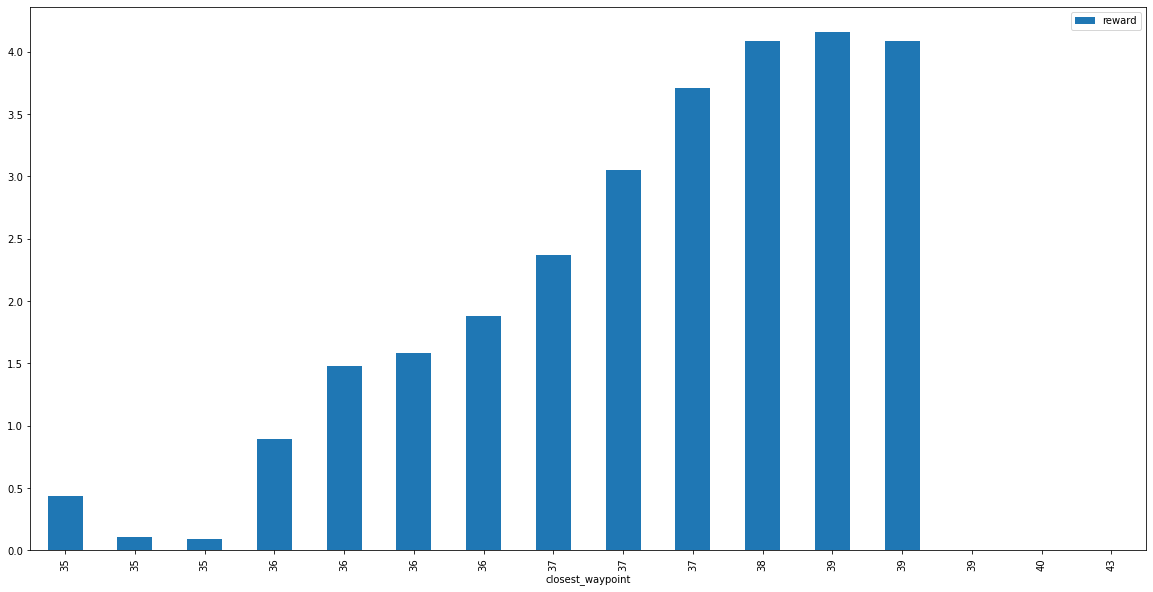

In [61]:
# This shows a histogram of actions per closest waypoint for episode 771.
# Will let you spot potentially problematic places in reward granting.
# In this example reward function is clearly `return 1`. It may be worrying
# if your reward function has some logic in it.
# If you have a final step reward that makes the rest of this histogram
# unreadable, you can filter the last step out by using
# `episode[:-1].plot.bar` instead of `episode.plot.bar`
episode = df[df['episode']==10]
episode.plot.bar(figsize=(20,10),x='closest_waypoint', y='reward')

In [71]:
def toCms(x):
    return x*100

def get_heading(optimal_race_line):
    racing_track = optimal_race_line
    headings=[]
    n=len(racing_track)
    for idx,point in enumerate(racing_track):
        track_direction = math.degrees(math.atan2(racing_track[(idx+1)%n][1]-point[1], racing_track[(idx+1)%n][0] - point[0]))
        headings.append(round(track_direction,2))
    return headings

def draw_track_plotly(fig, center_line=True):
    borderColor = 'rgb(189,189,189)'
    optLineColor = 'rgb(139,195,74)'
    if center_line :
        fig.add_trace(go.Scatter(x= l_center_line[:,0], y= l_center_line[:,1],
                        mode='lines',
                        line=dict(color=borderColor),
                        name='center_line',showlegend = False))
    fig.add_trace(go.Scatter(x= l_inner_border[:,0], y= l_inner_border[:,1],
                        mode='lines+markers',
                        line=dict(color=borderColor),
                        name='inner_border',showlegend = False))
    fig.add_trace(go.Scatter(x= l_outer_border[:,0], y= l_outer_border[:,1],
                        mode='lines+markers',
                        line=dict(color=borderColor),
                        name='outer_border',
                        showlegend = False))
    
#     headings = get_heading(center_line)

def plot_episode(episode_data):
    episode_data=episode_data[:-1]

    fig = go.Figure()
    fig=px.scatter(episode_data,x="x",y="y",color='throttle',
                          hover_data={'throttle' : True,'yaw':True,'x':True,'y':True,'steer':True,'reward':True,'closest_waypoint':True,"steps":True})
    draw_track_plotly(fig)
    fig.show()
    
episodes = [10]
for episode_no in episodes:
    episode_data = df[df['episode']==episode_no]
    plot_episode(episode_data)

In [73]:
def plot_multiple_laps(fig, episode_df,time_start=6.5,time_end=8.7,is_complete=True):
    episode_df = episode_df[ (episode_df['time'] >= time_start) & (episode_df['time'] <= time_end)]
    if is_complete == False :
        episode_df = episode_df[ episode_df['progress'] != 100 ]
        
    for idx, entry in episode_df.iterrows():
        episode_no = entry['episode']
        episode_data = df[df['episode'] == episode_no]
        reward_arr = episode_data['reward'].tolist()
        speed_arr = episode_data['throttle'].tolist()
        hover_arr = [list(x) for x in zip(reward_arr, speed_arr)]
        fig.add_trace(go.Scatter(x=episode_data['x'],y=episode_data['y'],
                                mode='markers',
                                marker=dict(size=4,color = reward_arr),
                                hovertemplate =
                                    '<b>%{text}</b>',
                                text = ['{}'.format([ entry[0],entry[1] ]) for entry in hover_arr],
                                name="ep : "+str(episode_no)))
        
fig = go.Figure()
plot_multiple_laps(fig,simulation_agg,7.0,8.0,False)
draw_track_plotly(fig)
fig.show()

### Path taken for top reward iterations

NOTE: at some point in a single episode the car could go around multiple laps, the episode was terminated when car completed 1000 steps. Currently one episode has at most one lap. This explains why you can see multiple laps in an episode plotted below.

Being able to plot the car's route in an episode can help you detect certain patterns in its behaviours and either promote them more or train away from them. While being able to watch the car go in the training gives some information, being able to reproduce it after the training is much more practical.

Graphs below give you a chance to look deeper into your car's behaviour on track.

In [93]:
#Path taken by top 5 fastest laps
sorted_episodes = list(complete_ones.nsmallest(5,'time')['episode'])
sorted_episodes = list(complete_ones.nlargest(3,'reward')['episode'])
sorted_episodes = list(complete_ones[complete_ones['start_at']==0].nsmallest(5,'time')['episode'])
for episode in sorted_episodes:
    episode_data = df[df['episode']==episode]
    fig = go.Figure()
    fig=px.scatter(episode_data,x="x",y="y",color='throttle',
                          hover_data={'throttle' : True,'yaw':True,'x':True,'y':True,'steer':True,'reward':True,'closest_waypoint':True},
                  width=900, height=600)
    draw_track_plotly(fig)
    fig.show()

### Plot a heatmap of rewards for current training. 
The brighter the colour, the higher the reward granted in given coordinates.
If instead of a similar view as in the example below you get a dark image with hardly any 
dots, it might be that your rewards are highly disproportionate and possibly sparse.

Disproportion means you may have one reward of 10.000 and the rest in range 0.01-1.
In such cases the vast majority of dots will simply be very dark and the only bright dot
might be in a place difficult to spot. I recommend you go back to the tables and show highest
and average rewards per step to confirm if this is the case. Such disproportions may
not affect your traning very negatively, but they will make the data less readable in this notebook.

Sparse data means that the car gets a high reward for the best behaviour and very low reward
for anything else, and worse even, reward is pretty much discrete (return 10 for narrow perfect,
else return 0.1). The car relies on reward varying between behaviours to find gradients that can
lead to improvement. If that is missing, the model will struggle to improve.

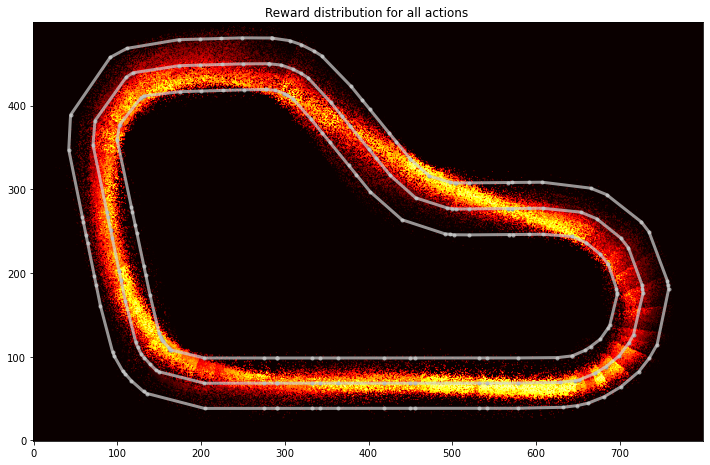

In [23]:
# Some tracks have negative coordinates for which `la.plot_track` is not ready. It has been improved
# using RichardFan's modification to offer an x_shift and y_shift parameters. They may require
# different values for other tracks. You will then need to change it in the future. Simply add parameters:
# track_size=(700,1000), y_shift=300 to this method
track = la.plot_track(df, l_center_line, l_inner_border, l_outer_border)


plt.title("Reward distribution for all actions ")
im = plt.imshow(track, cmap='hot', interpolation='bilinear', origin="lower") 

### Plot a particular iteration
This is same as the heatmap above, but just for a single iteration.

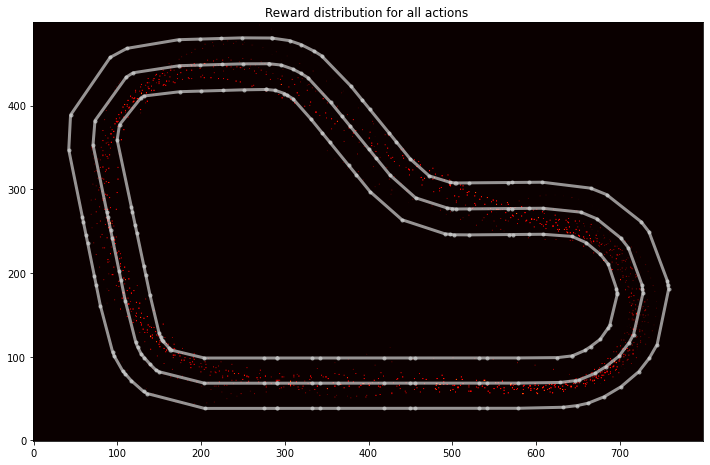

In [24]:
iteration_id = 100
track = la.plot_track(df[df['iteration'] == iteration_id], l_center_line, l_inner_border, l_outer_border)
plt.title("Reward distribution for all actions ")
im = plt.imshow(track, cmap='hot', interpolation='bilinear', origin="lower") 

# Action breakdown per iteration and historgram for action distribution for each of the turns - reinvent track

This plot is useful to understand the actions that the model takes for any given iteration. Unfortunately at this time it is not fit for purpose as it assumes six actions in the action space and has other issues. It will require some work to get it to done but the information it returns will be very valuable.

This is a bit of an attempt to abstract away from the brilliant function in the original notebook towards a more general graph that we could use. It should be treated as a work in progress. The track_breakdown could be used as a starting point for a general track information object to handle all the customisations needed in methods of this notebook.

A breakdown track data needs to be available for it. If you cannot find it for the desired track, MAKEIT.

Currently supported tracks:

In [94]:
la.track_breakdown.keys()

dict_keys(['reinvent2018', 'london_loop'])

The second parameter is either a single index or a list of indices for df iterations that you would like to view. You can for instance use `sorted_idx` list which is a sorted list of iterations from the highest to lowest reward.

Bear in mind that you will have to provide a proper action naming in parameter `action_names`, this function assumes only six actions by default. I think they need to match numbering of actions in your model's metadata json file.

<AxesSubplot:>

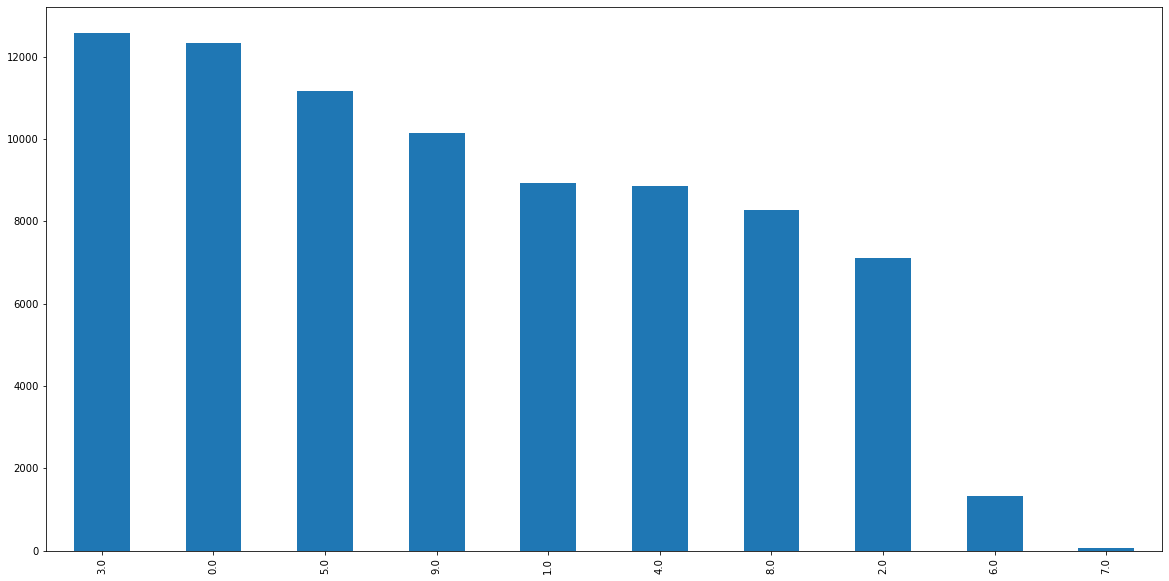

In [95]:
df[df['progress']<=100]['action'].value_counts().plot(kind='bar',figsize=(20,10))

Number of steps in iteration= 80808


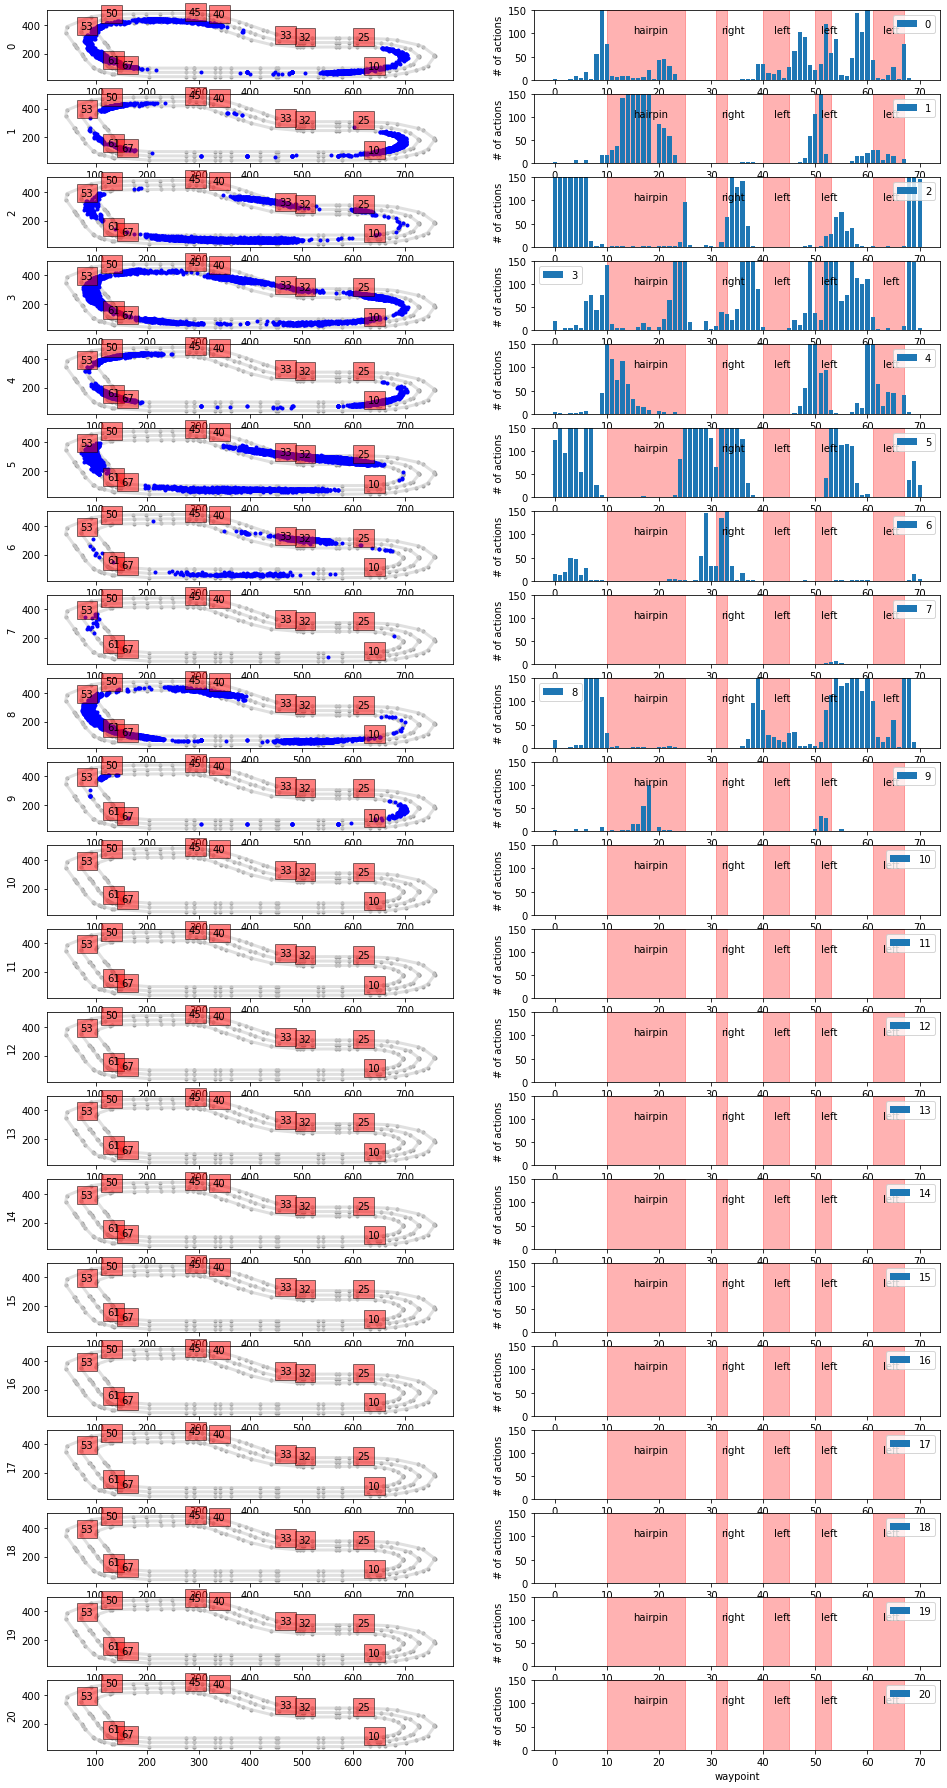

<Figure size 432x288 with 0 Axes>

In [96]:
la.action_breakdown(df, 4,df['iteration'], la.track_breakdown['reinvent2018'], l_center_line, l_inner_border, l_outer_border, ['0', '1', '2', '3',
                                   '4', '5', '6', '7', 
                                   '8', '9', '10', '11', 
                                   '12', '13', '14', '15',
                                   '16', '17', '18', '19', '20'])